In [20]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt


In [21]:
#Reading file into pandas data frame 

# Define the path to the folder containing the CSV files
folder_path = r"./Contract Pricing"

# List all files in the directory as List 
file_names = [
    'Contracts Pricing - July 24.csv',
    'Contracts Pricing - September 24.csv',
    'Contracts Pricing - December 24.csv',
    'Contracts Pricing - March 25.csv',
    'Contracts Pricing - May 25.csv',
    'Contracts Pricing - July 25.csv',
    'Contracts Pricing - September 25.csv',
    'Contracts Pricing - December 25.csv',
    'Contracts Pricing - March 26.csv',
    'Contracts Pricing - May 26.csv',
]

# Create an empty dictionary to store DataFrames
dataframes = {}

# Loop through each file and read it into a DataFrame
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name) 
    df_name = file_name.split('.')[0]  # Use the file name without extension as the DataFrame name
    dataframes[df_name] = pd.read_csv(file_path) 
    


In [22]:
# Cleaning Contarcts Pricing Data 
import pandas as pd
import numpy as np

#Adding Data Frames to list 
dfs_list = list(dataframes.values())

for df in dfs_list:
    # Convert the 'Date' column to datetime with the correct format
    df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], format="%m/%d/%Y")

    
    # Replace '-' with NaN in 'Adj Close' column
    df['Adj Close'].replace('-', np.nan, inplace=True)
    
    # Replace '-' with 0 in 'Volume' column
    df['Volume'].replace('-', 0, inplace=True)
    
    # Drop rows with NaN values in 'Adj Close' column
    df.dropna(subset=['Adj Close'], inplace=True)
    nan_values = df.isna().sum()
    
    #Finding time to maturity
    df['Time to Maturity'] = (df['Maturity Date'] - df['Date']).dt.days # Subtracts Calander dates 
    
     # Convert columns to to numeric type
    df['Adj Close'] = pd.to_numeric(df['Adj Close'])
    df['High'] = pd.to_numeric(df['High'])
    df['Low'] = pd.to_numeric(df['Low'])

    # Replace commas with empty string in 'Volume' column
    df['Volume'] = df['Volume'].str.replace(',', '')

    # Convert 'Volume' column to numeric type
    df['Volume'] = pd.to_numeric(df['Volume'])
    df['Volume'] = df['Volume'].fillna(0)

    # Convert 'Maturity Month/Year' column to numeric type
    df['Maturity Month'] = pd.to_numeric(df['Maturity Month'])
    df['Maturity Year'] = pd.to_numeric(df['Maturity Year'])






In [23]:
# Variables 


for df in dfs_list:
    df.iloc[:] = df.iloc[::-1].values
    
    # Daily Returns
    df['Returns'] = df['Adj Close'].pct_change() * 100

    df['Month Returns'] = df['Adj Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-30)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Adj Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Adj Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Adj Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Adj Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Adj Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Adj Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()


    print(df.head())


        Date    Open    High     Low   Close  Adj Close  Volume  \
0 2021-05-19     457  457.00  452.50   452.5     452.50     1.0   
1 2021-05-20  456.75  456.75  456.75  456.75     456.75     0.0   
2 2021-05-21  450.25  450.25  450.25  450.25     450.25     0.0   
3 2021-05-24   443.5  443.50  443.50   443.5     443.50     0.0   
4 2021-05-25     442  442.00  442.00     442     442.00     0.0   

   Maturity Month  Maturity Year Maturity Date  ...  MACD_signal  MACD_diff  \
0               6             24    2024-07-15  ...          NaN        NaN   
1               6             24    2024-07-15  ...          NaN        NaN   
2               6             24    2024-07-15  ...          NaN        NaN   
3               6             24    2024-07-15  ...          NaN        NaN   
4               6             24    2024-07-15  ...          NaN        NaN   

   Bollinger_upper  Bollinger_middle  Bollinger_lower  Bollinger_position  \
0              NaN               NaN         

In [24]:
#OLS

def ols(merged_df):
    merged_df = merged_df.dropna()

    #Specifying Axes 
    x_vars = ['Returns', 'Maturity Month', 'Maturity Year', 'Time to Maturity', 'Momentum RSI', 'Adj Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP']
    X = merged_df.loc[:, x_vars] #Selecting only from merged_df
    y = merged_df['Month Returns']

    #Training Model 

    #Training and Testing Data 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

    # Fit the OLS model
    X = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    #Model Evaluations 

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
    mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
    print(model.summary())
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error(MSE): {mse:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.title('Actual vs Predicted')
    plt.show()


OLS Summary Contracts Pricing - July 24:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     21.62
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           3.69e-36
Time:                        16:59:13   Log-Likelihood:                -1553.5
No. Observations:                 519   AIC:                             3131.
Df Residuals:                     507   BIC:                             3182.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

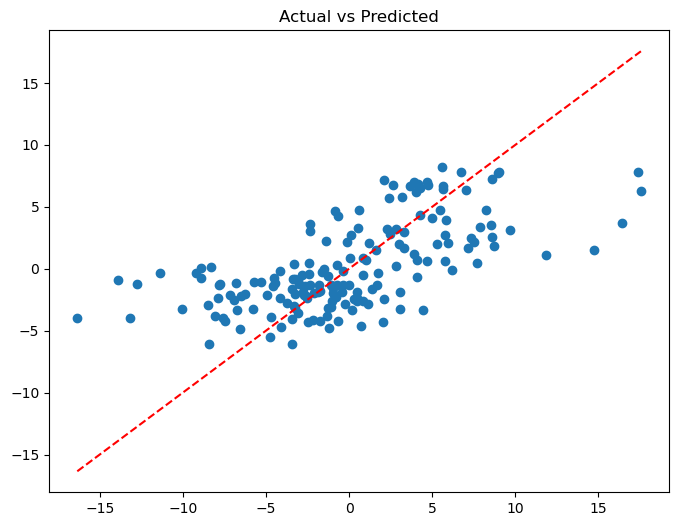



OLS Summary Contracts Pricing - September 24:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     21.69
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           2.20e-24
Time:                        16:59:13   Log-Likelihood:                -296.17
No. Observations:                 141   AIC:                             616.3
Df Residuals:                     129   BIC:                             651.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

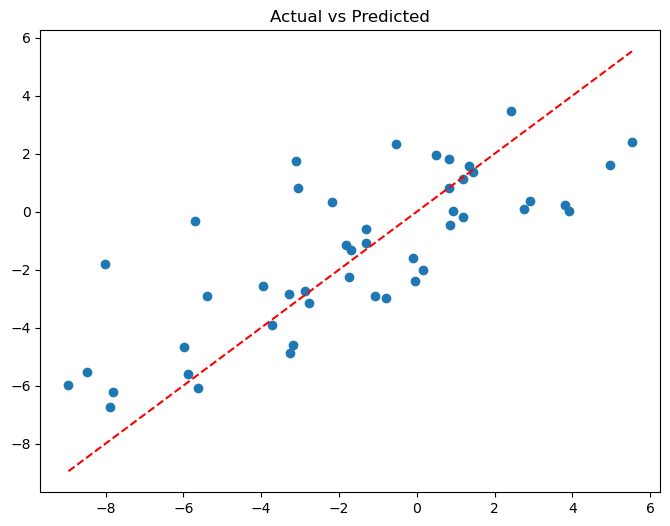



OLS Summary Contracts Pricing - December 24:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     22.02
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           8.68e-37
Time:                        16:59:14   Log-Likelihood:                -1448.4
No. Observations:                 519   AIC:                             2921.
Df Residuals:                     507   BIC:                             2972.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

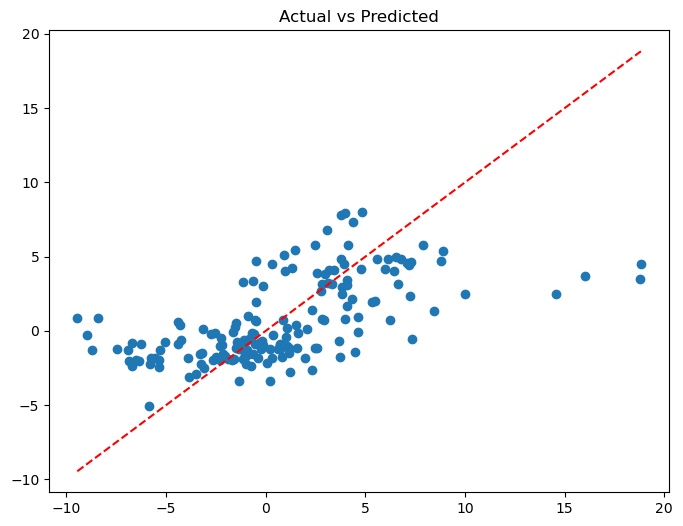



OLS Summary Contracts Pricing - March 25:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     18.17
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           4.21e-25
Time:                        16:59:14   Log-Likelihood:                -505.90
No. Observations:                 220   AIC:                             1036.
Df Residuals:                     208   BIC:                             1077.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

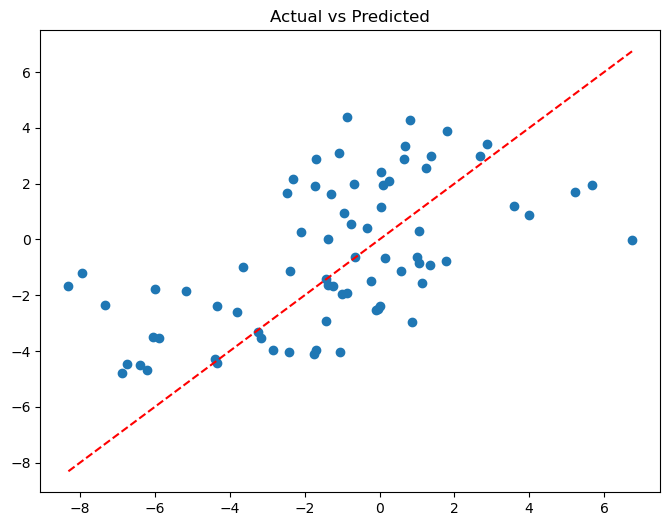



OLS Summary Contracts Pricing - May 25:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     23.58
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           7.21e-26
Time:                        16:59:14   Log-Likelihood:                -267.45
No. Observations:                 141   AIC:                             558.9
Df Residuals:                     129   BIC:                             594.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

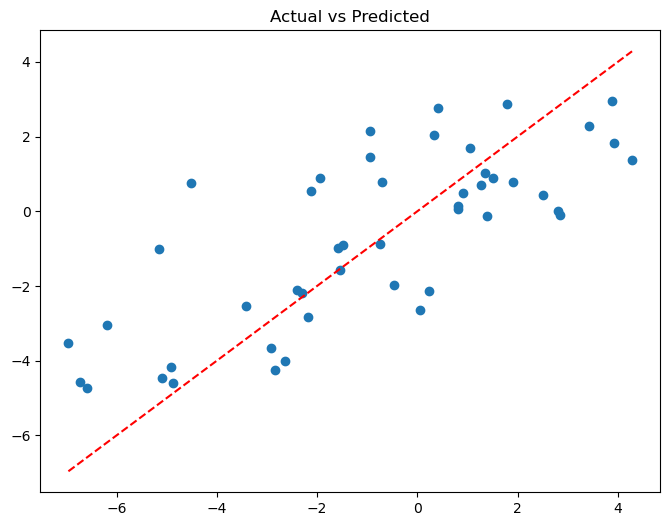



OLS Summary Contracts Pricing - July 25:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     21.33
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           7.19e-29
Time:                        16:59:14   Log-Likelihood:                -506.62
No. Observations:                 225   AIC:                             1037.
Df Residuals:                     213   BIC:                             1078.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

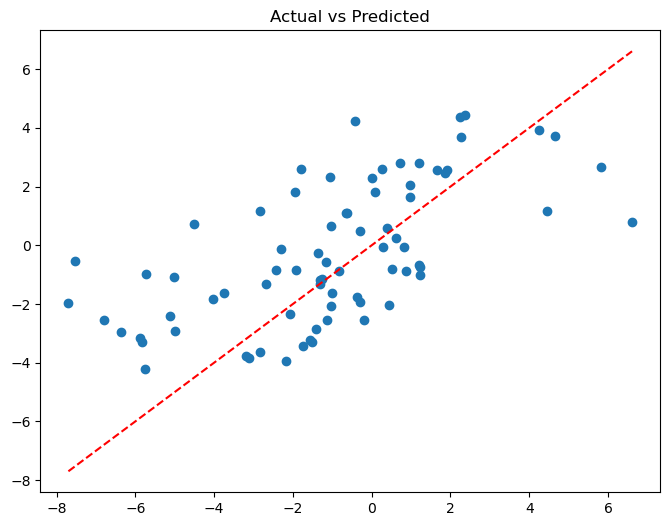



OLS Summary Contracts Pricing - September 25:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     21.02
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           1.19e-25
Time:                        16:59:14   Log-Likelihood:                -335.39
No. Observations:                 168   AIC:                             694.8
Df Residuals:                     156   BIC:                             732.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

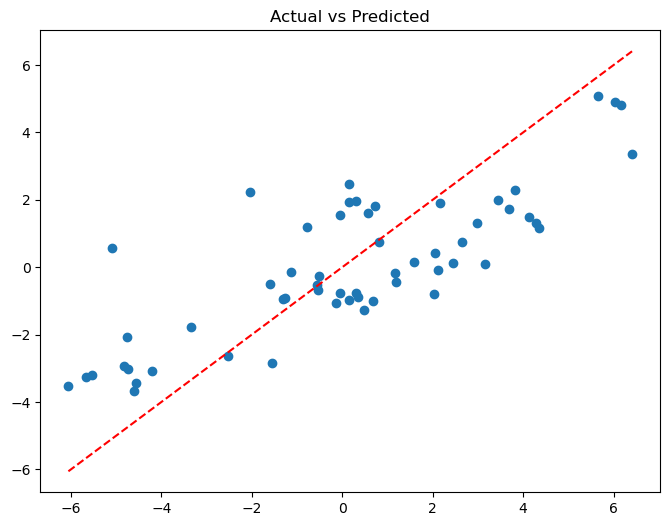



OLS Summary Contracts Pricing - December 25:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     67.49
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           6.93e-84
Time:                        16:59:15   Log-Likelihood:                -972.96
No. Observations:                 410   AIC:                             1970.
Df Residuals:                     398   BIC:                             2018.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

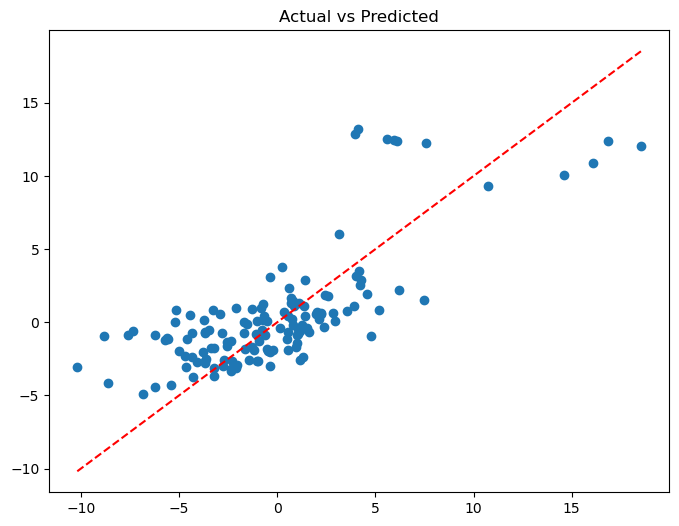



OLS Summary Contracts Pricing - March 26:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     4.509
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           0.000875
Time:                        16:59:15   Log-Likelihood:                -38.372
No. Observations:                  37   AIC:                             100.7
Df Residuals:                      25   BIC:                             120.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

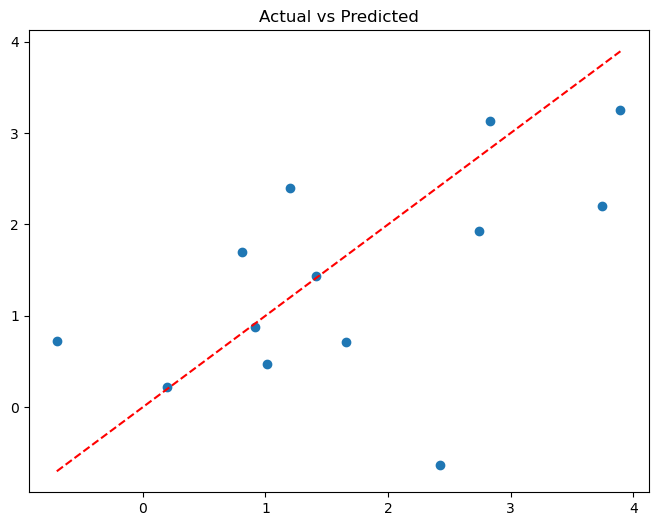



OLS Summary Contracts Pricing - May 26:
                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     4.690
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           0.000663
Time:                        16:59:15   Log-Likelihood:                -36.014
No. Observations:                  37   AIC:                             96.03
Df Residuals:                      25   BIC:                             115.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

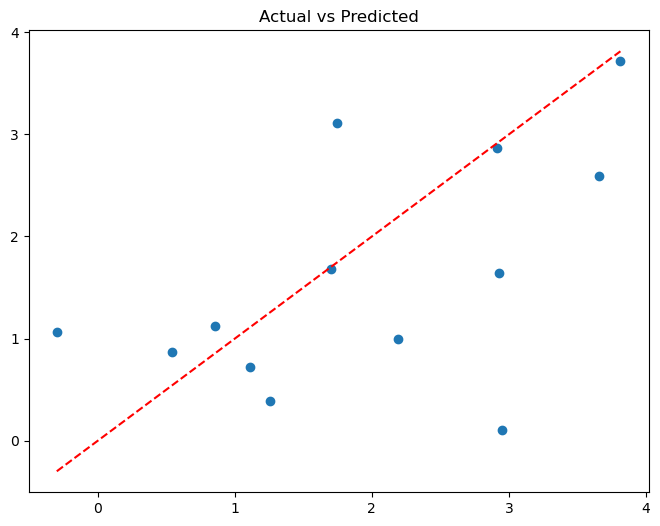

In [25]:
#Inputs for OLS 
merged_df = []
for name, df in dataframes.items():
    print(f'OLS Summary {name}:')
    ols(df)
    print('\n')

In [26]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [27]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
'''
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")
'''

[I 2024-06-06 13:27:09,130] A new study created in memory with name: no-name-0ad7ae0d-c1e2-4500-920e-b0d73c57397d
[I 2024-06-06 13:27:09,377] Trial 0 finished with value: 0.24402955758035655 and parameters: {'n_estimators': 275, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:09,726] Trial 1 finished with value: 0.2460772070541984 and parameters: {'n_estimators': 386, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:10,512] Trial 2 finished with value: 0.24472311933999805 and parameters: {'n_estimators': 879, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:10,710] Trial 3 finished with value: 0.2860878133929305 and parameters: {'n_estimators': 189, 'max_depth':

Best Hyperparameters: {'n_estimators': 237, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}
Mean Absolute Error (MAE): 0.41
Root Mean Squared Error (RMSE): 0.49
Mean Squared Error(MSE): 0.24


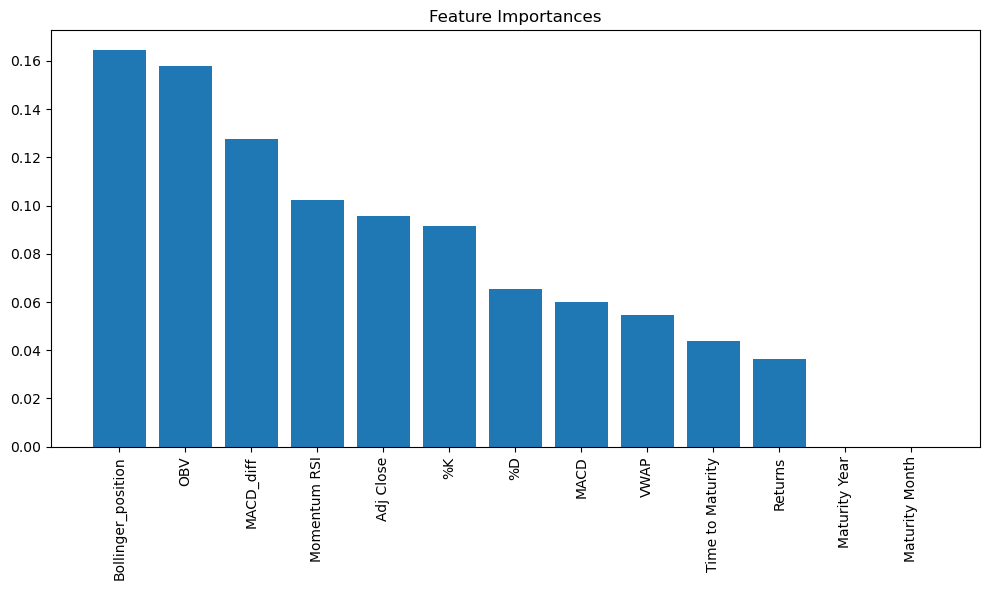

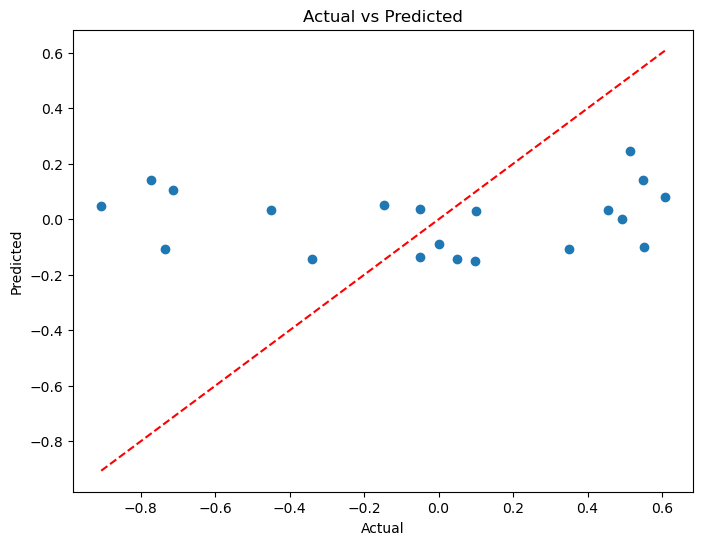

In [ ]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()